<h1> Deep Learning Small Project </h1>

In [1]:
%matplotlib inline

# Display
from IPython.display import Image

# Torch
import torch
from torch.utils.data import DataLoader
from torch import optim, nn

# Custom
import data
import model
import utils

Using Custom Dataloader, Data Split for First Layer classification task (normal vs infected)

In [2]:
fl_labels = {
0 : "Normal",
1 : "Infected"
}

fl_train = data.Lung_Dataset('train', verbose = 0)
fl_test = data.Lung_Dataset('test', verbose = 0)
fl_val = data.Lung_Dataset('val', verbose = 0)

"""
Data Split for Second Layer classification task (COVID vs Non-COVID) 
"""

sl_labels = {
0 : "COVID",
1 : "Non-COVID"
}

sl_train = data.Lung_Dataset('train', verbose = 2)
sl_test = data.Lung_Dataset('test', verbose = 2)
sl_val = data.Lung_Dataset('val', verbose = 2)

"""
Data Split for combined classification task (normal vs COVID vs Non-COVID) 
"""

combined_labels = {
0 : "Normal",
1 : "COVID",
2 : "Non-COVID"
}

final_val = data.Lung_Dataset('val', verbose = 1)
final_test = data.Lung_Dataset('test', verbose = 1)

Defining Model Parameters

In [3]:
N_EPOCH = 200
L_RATE = 0.001
BATCH_SIZE = 32
PATIENCE = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training the First Layer Model

Training the first model to classify normal and infected images


Epoch 1


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.6555038690567017
Validation set accuracy:  68.0 %


Epoch 2


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.7774753570556641
Validation set accuracy:  76.0 %


Epoch 3


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 1.379878282546997
Validation set accuracy:  68.0 %


Epoch 4


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.3730655014514923
Validation set accuracy:  80.0 %


Epoch 5


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.32787027955055237
Validation set accuracy:  88.0 %


Epoch 6


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.5709229111671448
Validation set accuracy:  72.0 %


Epoch 7


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.35647642612457275
Validation set accuracy:  84.0 %


Epoch 8


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.1459793597459793
Validation set accuracy:  96.0 %


Epoch 9


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.5893087387084961
Validation set accuracy:  80.0 %


Epoch 10


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 2.741182804107666
Validation set accuracy:  68.0 %


Epoch 11


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.8555300831794739
Validation set accuracy:  76.0 %


Epoch 12


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.6462427377700806
Validation set accuracy:  76.0 %


Epoch 13


  0%|          | 0/163 [00:00<?, ?it/s]

Validation loss: 0.5472099184989929
Validation set accuracy:  84.0 %



Test Accuracy of the first model:
Test set accuracy:  84.0650406504065 %


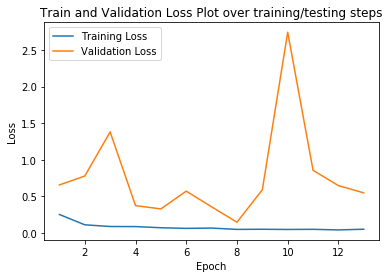

In [4]:
#First Model Training
fl_train_loader = DataLoader(fl_train, batch_size=BATCH_SIZE, shuffle=True)
fl_val_loader = DataLoader(fl_val, batch_size=BATCH_SIZE, shuffle=True)
fl_test_loader = DataLoader(fl_test, batch_size=BATCH_SIZE, shuffle=True)
    
fl_model = model.CNN().to(device)
fl_optimizer = optim.Adam(fl_model.parameters(), lr=L_RATE, weight_decay=0.0002)
    
print("Training the first model to classify normal and infected images")
model.train(fl_model, device, nn.BCELoss(), fl_optimizer, fl_train_loader, fl_val_loader, N_EPOCH, PATIENCE, "fl")

print("\n\n")
print("Test Accuracy of the first model:")
model.test(fl_model, device, fl_test_loader)

fl_model.to("cpu")
    
model.save_model(fl_model, fl_optimizer, './saved_models/fl_model.pth')

Training the Second Layer Model




Training the second model to classify COVID and non-COVID images


Epoch 1


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.8357553482055664
Validation set accuracy:  47.05882352941177 %


Epoch 2


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.7555397748947144
Validation set accuracy:  41.1764705882353 %


Epoch 3


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 1.0230308771133423
Validation set accuracy:  52.94117647058823 %


Epoch 4


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.7407584190368652
Validation set accuracy:  64.70588235294117 %


Epoch 5


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.7592189311981201
Validation set accuracy:  52.94117647058823 %


Epoch 6


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.7198694348335266
Validation set accuracy:  58.8235294117647 %


Epoch 7


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.7167891263961792
Validation set accuracy:  52.94117647058823 %


Epoch 8


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.7770504951477051
Validation set accuracy:  35.294117647058826 %


Epoch 9


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.6673769354820251
Validation set accuracy:  58.8235294117647 %


Epoch 10


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.7331817150115967
Validation set accuracy:  35.294117647058826 %


Epoch 11


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.672735869884491
Validation set accuracy:  58.8235294117647 %


Epoch 12


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.6770780682563782
Validation set accuracy:  64.70588235294117 %


Epoch 13


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.7644298076629639
Validation set accuracy:  52.94117647058823 %


Epoch 14


  0%|          | 0/122 [00:00<?, ?it/s]

Validation loss: 0.6785128116607666
Validation set accuracy:  58.8235294117647 %



Test Accuracy of the second model:
Test set accuracy:  73.75328083989501 %


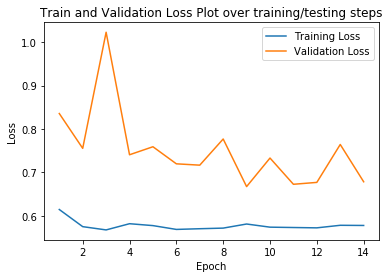

In [5]:
#Second Model Training
sl_train_loader = DataLoader(sl_train, batch_size=BATCH_SIZE, shuffle=True)
sl_val_loader = DataLoader(sl_val, batch_size=BATCH_SIZE, shuffle=True)
sl_test_loader = DataLoader(sl_test, batch_size=BATCH_SIZE, shuffle=True)
    
sl_model = model.CNN().to(device)  
sl_optimizer = optim.Adam(sl_model.parameters(), lr=L_RATE, weight_decay=0.04)
    
print("\n\n")
print("Training the second model to classify COVID and non-COVID images")
model.train(sl_model, device, nn.BCELoss(), sl_optimizer, sl_train_loader, sl_val_loader, N_EPOCH, PATIENCE, "sl")
    
print("\n\n")
print("Test Accuracy of the second model:")
model.test(sl_model, device, sl_test_loader)
    
sl_model.to("cpu")
    
model.save_model(sl_model, sl_optimizer, './saved_models/sl_model.pth')

Analyzing the performance of each model (first layer and second layer models) 

Learning Curve of the First Layer Model

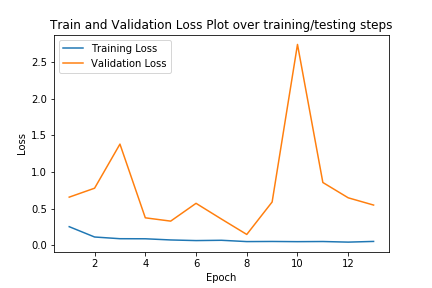

In [6]:
Image(filename='./saved_graphs/fl_learning_curve.png') 

Learning Curve of the Second Layer Model

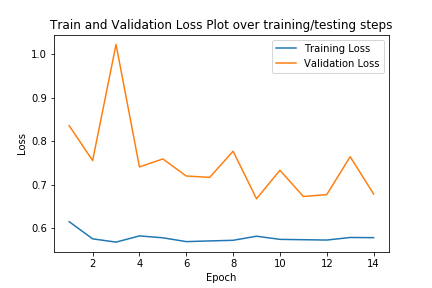

In [7]:
Image(filename='./saved_graphs/sl_learning_curve.png') 

Combine the 2 Models and Test the results on validation and test

Test set accuracy:  68.130081300813 %



Visualizing the Validation Set: 


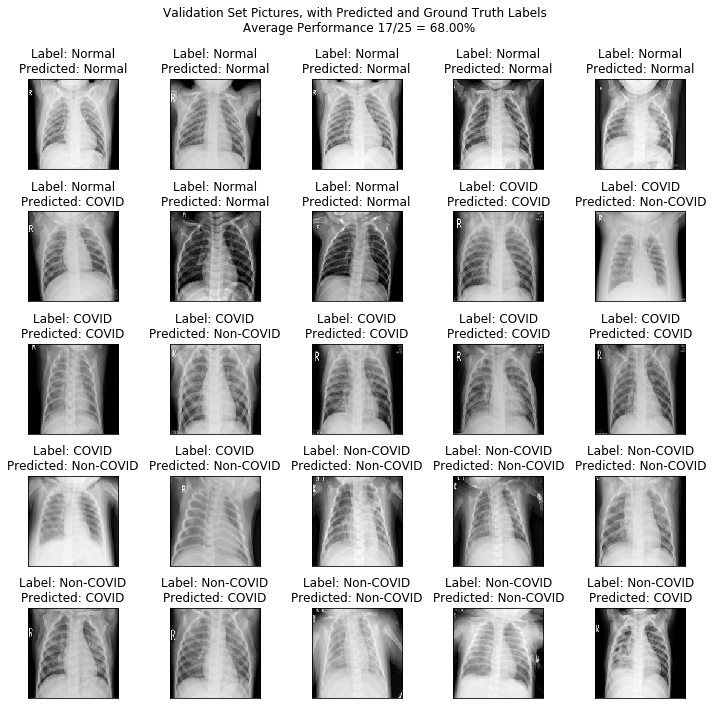

In [9]:
final_val_loader = DataLoader(final_val, batch_size=32, shuffle=False)
final_test_loader = DataLoader(final_test, batch_size=32, shuffle=True)
    
combined_model = model.combine_models('./saved_models/fl_model.pth','./saved_models/sl_model.pth',device,L_RATE)
combined_model.test_combine(device, final_test_loader, print_acc=True, return_results = False)

pred = combined_model.test_combine(device, final_val_loader, print_acc=False, return_results = True)
print("\n\n")
print("Visualizing the Validation Set: ")
utils.generate_performance_display(final_val_loader, pred, combined_labels)